In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Load in the csv file.
data = pd.read_csv('FinancialMarketData.csv')

# Display the first few rows of the data.
print(data.head())

   Y       Date  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

In [6]:
# Create a dataframe without the Data column to keep all values numeric.
date_col = data['Date']
df = data.drop('Date', axis=1)

# Store target variable (Y column)
y = df['Y']
X = df.drop('Y', axis=1)

print(df.head())

   Y  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP    Cl1    VIX  \
0  0    283.25     0.077  1388.0  157.26  100.56  105.86  1.646  25.77  22.50   
1  0    287.65     0.043  1405.0  165.01  101.86  105.47  1.638  28.85  21.50   
2  0    287.15     0.135  1368.0  167.24  102.41  106.04  1.650  28.28  23.02   
3  0    282.75     0.191  1311.0  166.85  104.92  107.85  1.611  28.22  23.45   
4  1    298.40     0.312  1277.0  165.43  104.22  109.30  1.611  28.02  21.25   

   ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34  34.30  
1  234.37  227

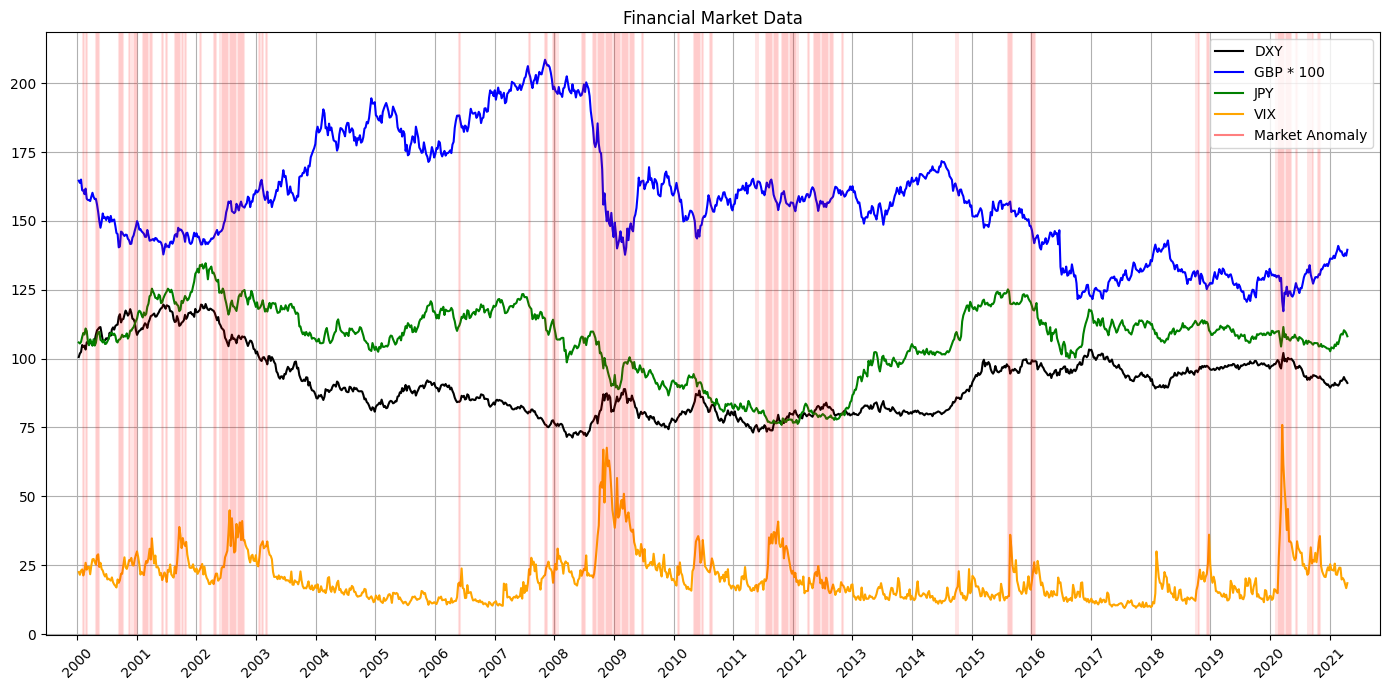

In [59]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Convert 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Create the plot
plt.figure(figsize=(14, 7))

# Plot 'DXY', 'GBP', and 'JPY'
plt.plot(data['Date'], data['DXY'], color='black', label='DXY')
plt.plot(data['Date'], data['GBP'] * 100, color='blue', label='GBP * 100')  # Multiply GBP values by 100
plt.plot(data['Date'], data['JPY'], color='green', label='JPY')
plt.plot(data['Date'], data['VIX'], color='orange', label='VIX')
# Dummy plot for red lines in legend
plt.plot([], [], color='red', alpha=0.5, label='Market Anomaly')

# Plot red dots and vertical lines for target values == 1
for index, row in data[data['Y'] == 1].iterrows():
    # plt.plot(row['Date'], row['GBP'] * 100, marker='.', markersize=8, color='red')
    plt.axvline(x=row['Date'], color='red', linestyle='-', alpha=0.1)

# Set x-axis limits to match data range, with some padding
padding = timedelta(days=200)
plt.xlim(data['Date'].min() - padding, data['Date'].max() + padding)

# Customize the plot
# plt.xlabel('Date')
# plt.ylabel('Values')
plt.title('Financial Market Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.show()

In [60]:
# Calculate the average DXY, GBP, JPY, and VIX values when Y is 1
avg_dxy_y1 = data[data['Y'] == 1]['DXY'].mean()
avg_gbp_y1 = data[data['Y'] == 1]['GBP'].mean()
avg_jpy_y1 = data[data['Y'] == 1]['JPY'].mean()
avg_vix_y1 = data[data['Y'] == 1]['VIX'].mean()

# Calculate the average DXY, GBP, JPY, and VIX values when Y is 0
avg_dxy_y0 = data[data['Y'] == 0]['DXY'].mean()
avg_gbp_y0 = data[data['Y'] == 0]['GBP'].mean()
avg_jpy_y0 = data[data['Y'] == 0]['JPY'].mean()
avg_vix_y0 = data[data['Y'] == 0]['VIX'].mean()

print("Average values when Y is 1:")
print(f"DXY: {avg_dxy_y1:.2f}")
print(f"GBP: {avg_gbp_y1:.2f}")
print(f"JPY: {avg_jpy_y1:.2f}")
print(f"VIX: {avg_vix_y1:.2f}")

print("\nAverage values when Y is 0:")
print(f"DXY: {avg_dxy_y0:.2f}")
print(f"GBP: {avg_gbp_y0:.2f}")
print(f"JPY: {avg_jpy_y0:.2f}")
print(f"VIX: {avg_vix_y0:.2f}")

Average values when Y is 1:
DXY: 93.19
GBP: 1.53
JPY: 102.88
VIX: 29.92

Average values when Y is 0:
DXY: 90.32
GBP: 1.58
JPY: 107.62
VIX: 17.30
